<a href="https://colab.research.google.com/github/walkerjian/Physics/blob/main/TransKalmania.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman Filters
 Developed by Rudolf E. Kalman in the 1960s, KF has been pivotal in areas ranging from guiding aircraft and spacecraft to enabling smartphones pinpoint their location. By blending data and mathematics, the Kalman Filter provides accurate estimates of future states.

## The Basics of a Kalman Filter
The KF estimates the state of a system by continually updating a set of covariance matrices derived from observations over time. It uniquely allows for expansion and refinement of the solution by defining mathematical relationships between the system and external factors. The process reduces to two steps: predict and update, iteratively correcting and refining the system's state estimates.

### Predict Step:
This phase forecasts the system's next state using known posteriori estimates and a time step, $\Delta k$. The state space estimates are represented as:
$$
\hat{x}_{k | k-1} = F_k \hat{x}_{k-1 | k-1} + B_k u_k
$$
Here, $F$, the state transition matrix, models the state evolution, while $B$ affects the state through the control input $\mathrm{u}_{\mathrm{k}}$.

We also estimate the uncertainty of the next state, represented by the covariance matrix $P$:
$$
P_{k | k-1} = F_k P_{k-1 | k-1} F_k^T + Q_k
$$
$P$ reflects the prediction's confidence and accuracy, influenced by $Q$, the process noise covariance matrix. This matrix is integral to subsequent equations in the update step for refining future state estimates.

### Update Step:
Here, the algorithm updates the Kalman Gain, state estimates, and covariance matrix. The Kalman Gain, $K$, influenced by the observation model matrix $H$ (linking the state to expected measurements) and the measurement noise covariance $R$, is calculated as:
$$
K_k = P_{k | k-1} H_k^T(H_k P_{k | k-1} H_k^T + R_k)^{-1}
$$
$K$ balances the uncertainty in predictions against measurement errors. The following equations correct the state estimates and covariance respectively:
$$
\begin{gathered}
\hat{x}_{k | k} = \hat{x}_{k | k-1} + K_k(y_k - H_k \hat{x}_{k | k-1}) \\
P_{k | k} = (I - K_k H_k) P_{k | k-1}
\end{gathered}
$$
The state estimate correction involves calculating the residual, i.e., the difference between the actual measurement and the model's prediction.

The Kalman Filter's recursive nature allows it to continuously update both the state and covariance with new information, refining the model in a statistically optimal manner. This is especially effective for systems with a continuous stream of noisy observations.

## The Kalman Filter in Action
While the underlying equations might seem daunting, their practical application becomes more intuitive with Python examples. We'll demonstrate a basic Kalman Filter implementation, revealing how these mathematical concepts translate into a dynamic, responsive model.

---

##A Note on Notation and Subscripts:
The subscript $ k-1|k-1 $ in the context of a Kalman Filter has a specific meaning related to the state estimation process. Let's break it down:

- **$ k $**: This represents the current time step in the filter's process.
- **$ k-1 $**: This indicates the previous time step.

When you see a notation like $\hat{x}_{k-1|k-1}$, it's describing the state estimate at time $ k-1 $, given all the information available up to and including time $ k-1 $. In simpler terms, it's the best estimate of the system's state at the previous time step, after considering all observations and data up to that point.

This notation is part of a more general form $ \hat{x}_{k|j} $, where $ k $ is the time step of the estimate, and $ j $ is the latest time step of the information used in the estimate. For instance:

- $ \hat{x}_{k|k-1} $ would be the estimate of the state at time $ k $ based on information available up to time $ k-1 $ (i.e., the "predict" step in Kalman Filtering, where future state is predicted based on past information).
- $ \hat{x}_{k|k} $ would then be the estimate of the state at time $ k $ after incorporating observations at time $ k $ (i.e., the "update" step, where the prediction is corrected using new data).

Understanding this notation is key to grasping how the Kalman Filter iteratively updates its estimates by incorporating new information at each time step.

In [7]:
import numpy as np

class KalmanFilter:
    """
    An implementation of the classic Kalman Filter for linear dynamic systems.
    The Kalman Filter is an optimal recursive data processing algorithm which
    aims to estimate the state of a system from noisy observations.

    Attributes:
        F (np.ndarray): The state transition matrix.
        B (np.ndarray): The control input marix.
        H (np.ndarray): The observation matrix.
        u (np.ndarray): the control input.
        Q (np.ndarray): The process noise covariance matrix.
        R (np.ndarray): The measurement noise covariance matrix.
        x (np.ndarray): The mean state estimate of the previous step (k-1).
        P (np.ndarray): The state covariance of previous step (k-1).
    """
    def __init__(self, F, B, u, H, Q, R, x0, P0):
        """
        Initializes the Kalman Filter with the necessary matrices and initial state.

        Parameters:
            F (np.ndarray): The state transition matrix.
            B (np.ndarray): The control input marix.
            H (np.ndarray): The observation matrix.
            u (np.ndarray): the control input.
            Q (np.ndarray): The process noise covariance matrix.
            R (np.ndarray): The measurement noise covariance matrix.
            x0 (np.ndarray): The initial state estimate.
            P0 (np.ndarray): The initial state covariance matrix.
        """
        self.F = F  # State transition matrix
        self.B = B  # Control input matrix
        self.u = u  # Control vector
        self.H = H  # Observation matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.x = x0  # Initial state estimate
        self.P = P0  # Initial estimate covariance

    def predict(self):
        """
        Predicts the state and the state covariance for the next time step.
        """
        self.x = self.F @ self.x + self.B @ self.u
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x

    def update(self, z):
        """
        Updates the state estimate with the latest measurement.

        Parameters:
            z (np.ndarray): The measurement at the current step.
        """
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        I = np.eye(self.P.shape[0])
        self.P = (I - K @ self.H) @ self.P

        return self.x

We will use the predict() and update() functions to iterate through the steps outlined earlier. The above design of the filter will work for any time-series, and to show how our estimates compare to actuals let’s construct a simple example:

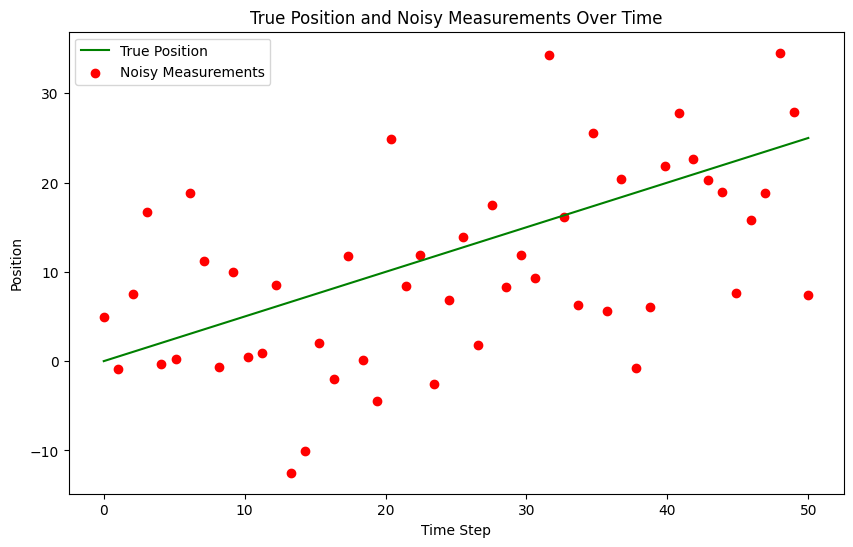

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)

# Simulate the ground truth position of the object
true_velocity = 0.5  # units per time step
num_steps = 50
time_steps = np.linspace(0, num_steps, num_steps)
true_positions = true_velocity * time_steps

# Simulate the measurements with noise
measurement_noise = 10  # increase this value to make measurements noisier
noisy_measurements = true_positions + np.random.normal(0, measurement_noise, num_steps)

# Plot the true positions and the noisy measurements
plt.figure(figsize=(10, 6))
plt.plot(time_steps, true_positions, label='True Position', color='green')
plt.scatter(time_steps, noisy_measurements, label='Noisy Measurements', color='red', marker='o')

plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('True Position and Noisy Measurements Over Time')
plt.legend()
plt.show()

In reality the ‘True Position’ would be unknown but we will plot it here for reference, the ‘Noisy Measurements’ are the observation points that are fed into our Kalman Filter. We will perform a very basic instantiation of the matrices, and to some degree it does not matter as the Kalman model will converge quickly through application of the Kalman Gain, but it might be reasonable under certain circumstances to perform a warm start to the model.

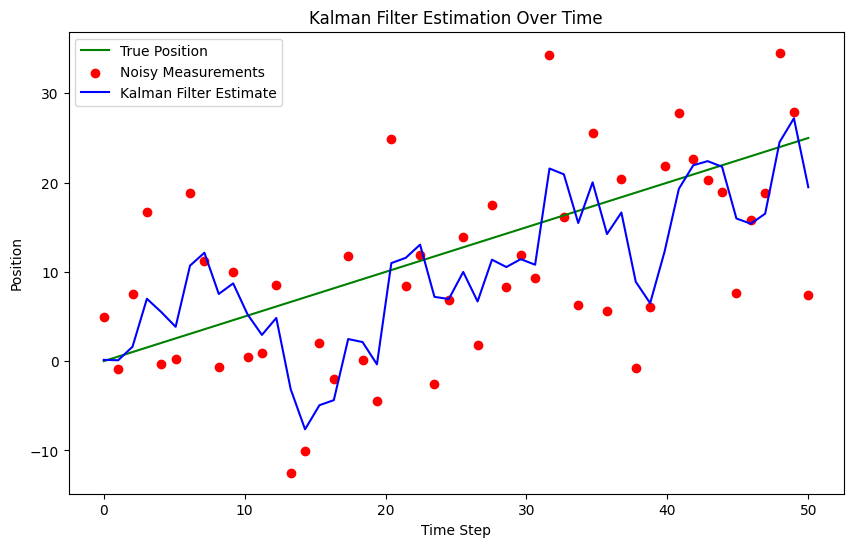

In [9]:
# Kalman Filter Initialization
F = np.array([[1, 1], [0, 1]])   # State transition matrix
B = np.array([[0], [0]])          # No control input
u = np.array([[0]])               # No control input
H = np.array([[1, 0]])            # Measurement function
Q = np.array([[1, 0], [0, 3]])    # Process noise covariance
R = np.array([[measurement_noise**2]]) # Measurement noise covariance
x0 = np.array([[0], [0]])         # Initial state estimate
P0 = np.array([[1, 0], [0, 1]])   # Initial estimate covariance

kf = KalmanFilter(F, B, u, H, Q, R, x0, P0)

# Allocate space for estimated positions and velocities
estimated_positions = np.zeros(num_steps)
estimated_velocities = np.zeros(num_steps)

# Kalman Filter Loop
for t in range(num_steps):
    # Predict
    kf.predict()

    # Update
    measurement = np.array([[noisy_measurements[t]]])
    kf.update(measurement)

    # Store the filtered position and velocity
    estimated_positions[t] = kf.x[0]
    estimated_velocities[t] = kf.x[1]

# Plot the true positions, noisy measurements, and the Kalman filter estimates
plt.figure(figsize=(10, 6))
plt.plot(time_steps, true_positions, label='True Position', color='green')
plt.scatter(time_steps, noisy_measurements, label='Noisy Measurements', color='red', marker='o')
plt.plot(time_steps, estimated_positions, label='Kalman Filter Estimate', color='blue')

plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('Kalman Filter Estimation Over Time')
plt.legend()
plt.show()

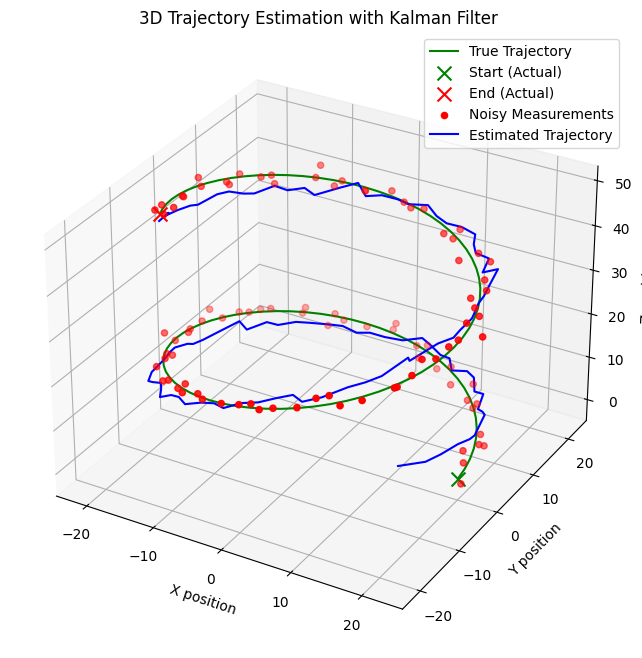

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class KalmanFilter:
    """
    An implementation of the classic Kalman Filter for linear dynamic systems.
    The Kalman Filter is an optimal recursive data processing algorithm which
    aims to estimate the state of a system from noisy observations.

    Attributes:
        F (np.ndarray): The state transition matrix.
        B (np.ndarray): The control input marix.
        H (np.ndarray): The observation matrix.
        u (np.ndarray): the control input.
        Q (np.ndarray): The process noise covariance matrix.
        R (np.ndarray): The measurement noise covariance matrix.
        x (np.ndarray): The mean state estimate of the previous step (k-1).
        P (np.ndarray): The state covariance of previous step (k-1).
    """
    def __init__(self, F=None, B=None, u=None, H=None, Q=None, R=None, x0=None, P0=None):
        """
        Initializes the Kalman Filter with the necessary matrices and initial state.

        Parameters:
            F (np.ndarray): The state transition matrix.
            B (np.ndarray): The control input marix.
            H (np.ndarray): The observation matrix.
            u (np.ndarray): the control input.
            Q (np.ndarray): The process noise covariance matrix.
            R (np.ndarray): The measurement noise covariance matrix.
            x0 (np.ndarray): The initial state estimate.
            P0 (np.ndarray): The initial state covariance matrix.
        """
        self.F = F  # State transition matrix
        self.B = B  # Control input matrix
        self.u = u  # Control input
        self.H = H  # Observation matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.x = x0  # Initial state estimate
        self.P = P0  # Initial estimate covariance

    def predict(self):
        """
        Predicts the state and the state covariance for the next time step.
        """
        self.x = np.dot(self.F, self.x) + np.dot(self.B, self.u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q

    def update(self, z):
        """
        Updates the state estimate with the latest measurement.

        Parameters:
            z (np.ndarray): The measurement at the current step.
        """
        y = z - np.dot(self.H, self.x)
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        self.P = self.P - np.dot(np.dot(K, self.H), self.P)

# Parameters for simulation
true_angular_velocity = 0.1  # radians per time step
radius = 20
num_steps = 100
dt = 1  # time step

# Create time steps
time_steps = np.arange(0, num_steps*dt, dt)

# Ground truth state
true_x_positions = radius * np.cos(true_angular_velocity * time_steps)
true_y_positions = radius * np.sin(true_angular_velocity * time_steps)
true_z_positions = 0.5 * time_steps  # constant velocity in z

# Create noisy measurements
measurement_noise = 1.0
noisy_x_measurements = true_x_positions + np.random.normal(0, measurement_noise, num_steps)
noisy_y_measurements = true_y_positions + np.random.normal(0, measurement_noise, num_steps)
noisy_z_measurements = true_z_positions + np.random.normal(0, measurement_noise, num_steps)

# Kalman Filter initialization
F = np.array([[1, 0, 0, -radius*dt*np.sin(true_angular_velocity*dt)],
              [0, 1, 0, radius*dt*np.cos(true_angular_velocity*dt)],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
B = np.zeros((4, 1))
u = np.zeros((1, 1))
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0]])
Q = np.eye(4) * 0.1  # Small process noise
R = measurement_noise**2 * np.eye(3)  # Measurement noise
x0 = np.array([[0], [radius], [0], [true_angular_velocity]])
P0 = np.eye(4) * 1.0

kf = KalmanFilter(F, B, u, H, Q, R, x0, P0)

# Allocate space for estimated states
estimated_states = np.zeros((num_steps, 4))

# Kalman Filter Loop
for t in range(num_steps):
    # Predict
    kf.predict()

    # Update
    z = np.array([[noisy_x_measurements[t]],
                  [noisy_y_measurements[t]],
                  [noisy_z_measurements[t]]])
    kf.update(z)

    # Store the state
    estimated_states[t, :] = kf.x.ravel()

# Extract estimated positions
estimated_x_positions = estimated_states[:, 0]
estimated_y_positions = estimated_states[:, 1]
estimated_z_positions = estimated_states[:, 2]

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the true trajectory
ax.plot(true_x_positions, true_y_positions, true_z_positions, label='True Trajectory', color='g')
# Plot the start and end markers for the true trajectory
ax.scatter(true_x_positions[0], true_y_positions[0], true_z_positions[0], label='Start (Actual)', c='green', marker='x', s=100)
ax.scatter(true_x_positions[-1], true_y_positions[-1], true_z_positions[-1], label='End (Actual)', c='red', marker='x', s=100)


# Plot the noisy measurements
ax.scatter(noisy_x_measurements, noisy_y_measurements, noisy_z_measurements, label='Noisy Measurements', color='r')

# Plot the estimated trajectory
ax.plot(estimated_x_positions, estimated_y_positions, estimated_z_positions, label='Estimated Trajectory', color='b')

# Plot settings
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Z position')
ax.set_title('3D Trajectory Estimation with Kalman Filter')
ax.legend()

plt.show()

## The Extended Kalman Filter
In scenarios where the forces acting on a system are nonlinear, the Kalman Filter (KF) might fall short. For such cases, we turn to the Extended Kalman Filter (EKF), an advanced variant designed to handle nonlinearity. Unlike the classic KF, the EKF employs the Jacobian matrix and Taylor series expansions to approximate nonlinear dynamics and observations.

## Understanding the EKF Equations
The EKF modifies the key algorithmic calculations of the standard Kalman Filter to account for nonlinearity:

1. **State Prediction**:
   $$ \hat{x}_{k \mid k-1} = f(\hat{x}_{k-1 \mid k-1}, u_{k-1}) $$
   Here, $ f $ represents the nonlinear state transition function, applying to the previous state estimate and the control input at the previous time step.

2. **Error Covariance Prediction**:
   $$ P_{k \mid k-1} = F_{k-1} P_{k-1 \mid k-1} F_{k-1}^T + Q_{k-1} $$
   $ F $ is the Jacobian of the state transition function, reflecting how small changes in the state estimate affect the prediction. $ Q $ remains the process noise covariance matrix.

3. **Observation Modeling**:
   $$ z_k = h(\hat{x}_{k \mid k-1}) + v_k $$
   The observation $ z $ at time $ k $ is modeled using $ h $, the nonlinear observation function, and some observation noise $ v $.

4. **Kalman Gain Update**:
   $$ K_k = P_{k \mid k-1} H_k^T(H_k P_{k \mid k-1} H_k^T + R_k)^{-1} $$
   $ H $ is the Jacobian of the observation function, and $ R $ is the measurement noise covariance.

5. **State Estimate Update**:
   $$ \hat{x}_{k \mid k} = \hat{x}_{k \mid k-1} + K_k(z_k - h(\hat{x}_{k \mid k-1})) $$
   This equation adjusts the state estimate by the Kalman Gain and the observed vs. predicted measurement difference.

6. **Error Covariance Update**:
   $$ P_{k \mid k} = (I - K_k H_k) P_{k \mid k-1} $$
   It refines the error covariance, incorporating the updated Kalman Gain.

## Challenges and Performance
Designing an EKF is more complex than a standard KF. The approximation of nonlinearities through the Jacobian introduces potential errors, and calculating the Jacobian can be computationally demanding. Despite these challenges, a well-implemented EKF can outperform the KF in systems with nonlinear dynamics.

Next, we'll explore a Python implementation of the EKF, building on our previous KF example, and applying it to a scenario with nonlinear dynamics, such as angular rotation.

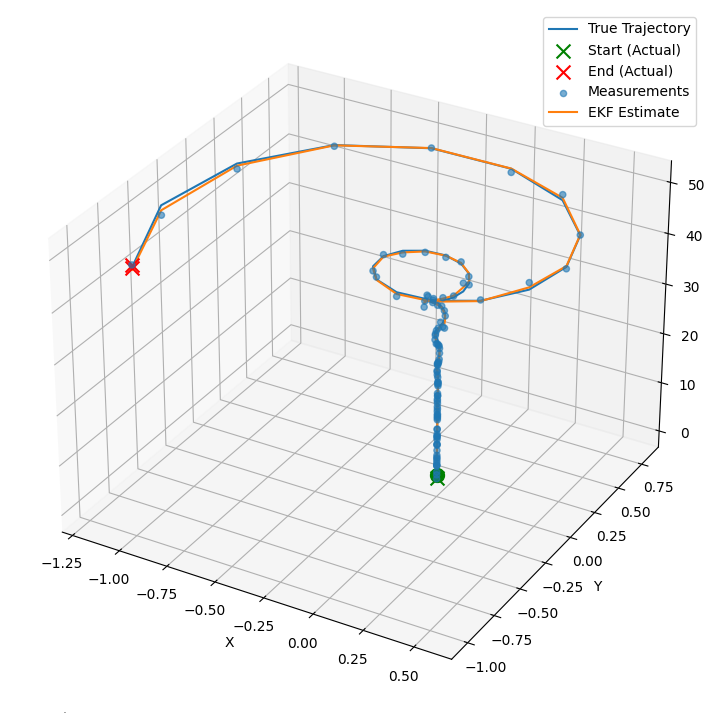

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class ExtendedKalmanFilter:
    """
    An implementation of the Extended Kalman Filter (EKF).
    This filter is suitable for systems with non-linear dynamics by linearising
    the system model at each time step using the Jacobian.

    Attributes:
        state_transition (callable): The state transition function for the system.
        jacobian_F (callable): Function to compute the Jacobian of the state transition.
        H (np.ndarray): The observation matrix.
        jacobian_H (callable): Function to compute the Jacobian of the observation model.
        Q (np.ndarray): The process noise covariance matrix.
        R (np.ndarray): The measurement noise covariance matrix.
        x (np.ndarray): The initial state estimate.
        P (np.ndarray): The initial estimate covariance.
    """
    def __init__(self, state_transition, jacobian_F, observation_matrix, jacobian_H, Q, R, x, P):
        """
        Constructs the Extended Kalman Filter.

        Parameters:
            state_transition (callable): The state transition function.
            jacobian_F (callable): Function to compute the Jacobian of F.
            observation_matrix (np.ndarray): Observation matrix.
            jacobian_H (callable): Function to compute the Jacobian of H.
            Q (np.ndarray): Process noise covariance.
            R (np.ndarray): Measurement noise covariance.
            x (np.ndarray): Initial state estimate.
            P (np.ndarray): Initial estimate covariance.
        """
        self.state_transition = state_transition  # Non-linear state transition function
        self.jacobian_F = jacobian_F  # Function to compute Jacobian of F
        self.H = observation_matrix  # Observation matrix
        self.jacobian_H = jacobian_H  # Function to compute Jacobian of H
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.x = x  # Initial state estimate
        self.P = P  # Initial estimate covariance

    def predict(self, u):
        """
        Predicts the state at the next time step.

        Parameters:
            u (np.ndarray): The control input vector.
        """
        self.x = self.state_transition(self.x, u)
        F = self.jacobian_F(self.x, u)
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z):
        """
        Updates the state estimate with a new measurement.

        Parameters:
            z (np.ndarray): The measurement vector.
        """
        H = self.jacobian_H()
        y = z - self.H @ self.x
        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(len(self.x)) - K @ H) @ self.P

# Define the non-linear transition and Jacobian functions
def state_transition(x, u):
    """
    Defines the state transition function for the system with non-linear dynamics.

    Parameters:
        x (np.ndarray): The current state vector.
        u (np.ndarray): The control input vector containing time step and rate of change of angular velocity.

    Returns:
        np.ndarray: The next state vector as predicted by the state transition function.
    """
    dt = u[0]
    alpha = u[1]
    x_next = np.array([
        x[0] - x[3] * x[1] * dt,
        x[1] + x[3] * x[0] * dt,
        x[2] + x[3] * dt,
        x[3],
        x[4] + alpha * dt
    ])
    return x_next

def jacobian_F(x, u):
    """
    Computes the Jacobian matrix of the state transition function.

    Parameters:
        x (np.ndarray): The current state vector.
        u (np.ndarray): The control input vector containing time step and rate of change of angular velocity.

    Returns:
        np.ndarray: The Jacobian matrix of the state transition function at the current state.
    """
    dt = u[0]
    # Compute the Jacobian matrix of the state transition function
    F = np.array([
        [1, -x[3]*dt, 0, -x[1]*dt, 0],
        [x[3]*dt, 1, 0, x[0]*dt, 0],
        [0, 0, 1, dt, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]
    ])
    return F

def jacobian_H():
    # Jacobian matrix for the observation function is simply the observation matrix
    return H

# Simulation parameters
num_steps = 100
dt = 1.0
alpha = 0.01  # Rate of change of angular velocity

# Observation matrix, assuming we can directly observe the x, y, and z position
H = np.eye(3, 5)

# Process noise covariance matrix
Q = np.diag([0.1, 0.1, 0.1, 0.1, 0.01])

# Measurement noise covariance matrix
R = np.diag([0.5, 0.5, 0.5])

# Initial state estimate and covariance
x0 = np.array([0, 20, 0, 0.5, 0.1])  # [x, y, z, v, omega]
P0 = np.eye(5)

# Instantiate the EKF
ekf = ExtendedKalmanFilter(state_transition, jacobian_F, H, jacobian_H, Q, R, x0, P0)

# Generate true trajectory and measurements
true_states = []
measurements = []
for t in range(num_steps):
    u = np.array([dt, alpha])
    true_state = state_transition(x0, u)  # This would be your true system model
    true_states.append(true_state)
    measurement = true_state[:3] + np.random.multivariate_normal(np.zeros(3), R)  # Simulate measurement noise
    measurements.append(measurement)
    x0 = true_state  # Update the true state

# Now we run the EKF over the measurements
estimated_states = []
for z in measurements:
    ekf.predict(u=np.array([dt, alpha]))
    ekf.update(z=np.array(z))
    estimated_states.append(ekf.x)

# Convert lists to arrays for plotting
true_states = np.array(true_states)
measurements = np.array(measurements)
estimated_states = np.array(estimated_states)

# Plotting the results
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the true trajectory
ax.plot(true_states[:, 0], true_states[:, 1], true_states[:, 2], label='True Trajectory')
# Increase the size of the start and end markers for the true trajectory
ax.scatter(true_states[0, 0], true_states[0, 1], true_states[0, 2], label='Start (Actual)', c='green', marker='x', s=100)
ax.scatter(true_states[-1, 0], true_states[-1, 1], true_states[-1, 2], label='End (Actual)', c='red', marker='x', s=100)

# Plot the measurements
ax.scatter(measurements[:, 0], measurements[:, 1], measurements[:, 2], label='Measurements', alpha=0.6)
# Plot the start and end markers for the measurements
ax.scatter(measurements[0, 0], measurements[0, 1], measurements[0, 2], c='green', marker='o', s=100)
ax.scatter(measurements[-1, 0], measurements[-1, 1], measurements[-1, 2], c='red', marker='x', s=100)

# Plot the EKF estimate
ax.plot(estimated_states[:, 0], estimated_states[:, 1], estimated_states[:, 2], label='EKF Estimate')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

##Summary

In our exploration of predictive algorithms, we've delved into two key models: the Kalman Filter (KF) and the Extended Kalman Filter (EKF).

**KF**: Suited for linear systems, the KF effectively handles scenarios where state transitions and observations are linearly related to the state, incorporating Gaussian noise. It is ideal for:
- Tracking objects moving at constant speeds.
- Signal processing where noise follows linear patterns.
- Linearly modeled economic forecasting.

The KF's strengths lie in its simplicity, computational efficiency, and accuracy in forecasting and estimating system states over time. However, its primary limitation is the assumption of linearity, which may not hold in more complex real-world situations.

**EKF**: Serving as the nonlinear counterpart to the KF, the EKF incorporates the Jacobian matrix to handle systems with nonlinear dynamics or observations. It is particularly useful for:
- Robotic systems with nonlinear measurement and dynamics.
- Tracking and navigation in scenarios involving variable velocities or angular rates, like in aircraft or spacecraft tracking.
- Advanced automotive functions like cruise control or lane-keeping in modern cars.

The EKF often outperforms the KF in nonlinear environments. However, its computational demands are higher due to the Jacobian matrix calculations. The reliance on first-order linear approximations (from Taylor series expansion) may not always be suitable for highly nonlinear systems. While the EKF offers enhanced capabilities, its complexity in design and implementation means that the KF might still be preferred for its simplicity and ease of integration in certain applications.